<a href="https://colab.research.google.com/github/ShFANI/ShFANI.github.io/blob/main/colorectal_cancer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Colorectal Cancer  Segmentation (Deep Learning, PyTorch)**

This notebook demonstrates an end-to-end **deep learning workflow for histopathology segmentation** using the **EBHI-SEG** dataset (H&E patches with paired pixel-wise labels).

## Objective
- How pathology segmentation datasets are typically organized (**image/mask pairs**) and how we build a training list.
- A practical training pipeline for segmentation:
  1) **Load & sanity-check data**
  2) **Train/validation split** (stratified by class)
  3) **Augmentations** appropriate for H&E
  4) **Model**: U-Net with an ImageNet-pretrained encoder
  5) **Loss**: BCE + Dice (handles imbalance and boundary quality)
  6) **Metrics**: Dice coefficient
  7) **Inference visualizations** (mask + overlay)

- Each **image** is an RGB H&E patch.
- Each **label** is a grayscale mask aligned to the image.

- In this notebook we use **binary segmentation** by default: `mask = (label > 0)`.
  - If your labels encode multiple regions/classes, you can extend this to **multi-class segmentation**.




## 0) Environment setup
We install:
- **segmentation-models-pytorch** for U-Net + pretrained encoders
- **albumentations** for strong, fast image augmentations
- **opencv** for image IO
- **tqdm/matplotlib** for progress + plots


In [ ]:
# ============================================
# 0) Install dependencies
# ============================================
!pip -q install -U segmentation-models-pytorch albumentations opencv-python tqdm matplotlib

import os, glob, random
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import albumentations as A
import segmentation_models_pytorch as smp
import zipfile


## 1) Configuration

- `img_size`: input resolution (224 is a good start)
- `batch_size`: reduce if you run out of GPU memory
- `epochs`: increase for better performance once the pipeline is validated
- `multitask`: set `False` if you only want segmentation
- `mask_threshold`: how we convert grayscale labels into binary masks


In [ ]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class CFG:
    ZIP_PATH: str = "/content/Colorectal.zip" # Updated path for Colab
    DATA_DIR: str = str(Path("/content") / "data") # Use /content/data for consistency in Colab
    DATASET_ROOT: str = "EBHI-SEG"

    # Training parameters
    seed: int = 42
    img_size: int = 224
    batch_size: int = 16
    num_workers: int = 2
    epochs: int = 12
    lr: float = 3e-4
    weight_decay: float = 1e-4

    # Multi-task
    multitask: bool = True
    cls_loss_weight: float = 0.2

    # Mixed precision
    amp: bool = True

    # Threshold for converting grayscale label to binary mask
    mask_threshold: int = 0  # mask = (label > 0)


In [ ]:
import random
import numpy as np
import torch

cfg = CFG()

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(cfg.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 2) Load the dataset
This section unzips your dataset and verifies the expected folder structure exists.


In [ ]:
import os
import zipfile
from pathlib import Path

# ============================================
# 2) Unzip data (Colab upload version)
# ============================================

# If you're in Colab, upload the zip
try:
    from google.colab import files
    uploaded = files.upload()  # choose Colorectal.zip from your computer
    uploaded_name = next(iter(uploaded))  # first uploaded file name
    cfg.ZIP_PATH = str(Path("/content") / uploaded_name)
    print("Uploaded ZIP to:", cfg.ZIP_PATH)
except Exception as e:
    print("Not in Colab or upload skipped:", e)

# Make data dir
Path(cfg.DATA_DIR).mkdir(parents=True, exist_ok=True)

zip_path = Path(cfg.ZIP_PATH)
if not zip_path.exists():
    raise FileNotFoundError(
        f"ZIP not found at {zip_path}. "
        f"Tip: In Colab, upload the zip, or set cfg.ZIP_PATH to something like '/content/Colorectal.zip'."
    )

# Extract
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall(cfg.DATA_DIR)

dataset_path = Path(cfg.DATA_DIR) / cfg.DATASET_ROOT
print("Dataset path:", dataset_path)
print("Top-level contents:", os.listdir(dataset_path))


Saving Colorectal.zip to Colorectal.zip
Uploaded ZIP to: /content/Colorectal.zip
Dataset path: /content/data/EBHI-SEG
Top-level contents: ['Serrated adenoma', 'Adenocarcinoma', 'Normal', 'High-grade IN', 'Polyp', 'Low-grade IN', 'readme.md']


## 3) Build the training table (image ↔ mask pairing)
We scan each class folder and match each `image/<name>.png` with `label/<name>.png`.
This creates a list of tuples: `(image_path, mask_path, class_id)`.


In [ ]:
import os, glob
from typing import List, Tuple

# Build the dataset path safely
DATASET_PATH = os.path.join(CFG.DATA_DIR, CFG.DATASET_ROOT)

print("DATASET_PATH:", DATASET_PATH)
print("Exists?", os.path.exists(DATASET_PATH))
print("Top-level folders:", os.listdir(DATASET_PATH)[:10])


DATASET_PATH: /content/data/EBHI-SEG
Exists? True
Top-level folders: ['Serrated adenoma', 'Adenocarcinoma', 'Normal', 'High-grade IN', 'Polyp', 'Low-grade IN', 'readme.md']


In [ ]:
# ============================================
# 3) Collect (image, mask, class_id) pairs
# Expected structure: EBHI-SEG/<ClassName>/{image,label}/*.png
# ============================================
CLASS_NAMES = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
CLASS_NAMES = sorted(CLASS_NAMES)
CLASS_TO_ID = {c: i for i, c in enumerate(CLASS_NAMES)}

print("Classes:", CLASS_NAMES)

def collect_pairs(dataset_path: str) -> List[Tuple[str, str, int]]:
    pairs = []
    for cls in CLASS_NAMES:
        img_dir = os.path.join(dataset_path, cls, "image")
        msk_dir = os.path.join(dataset_path, cls, "label")
        img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))
        for ip in img_paths:
            fn = os.path.basename(ip)
            mp = os.path.join(msk_dir, fn)
            if os.path.exists(mp):
                pairs.append((ip, mp, CLASS_TO_ID[cls]))
    return pairs

pairs = collect_pairs(DATASET_PATH)
print("Total matched (image, label) pairs:", len(pairs))

from collections import Counter
cc = Counter([p[2] for p in pairs])
print("Counts per class:")
for k, v in sorted(cc.items()):
    print(f"  {CLASS_NAMES[k]}: {v}")


Classes: ['Adenocarcinoma', 'High-grade IN', 'Low-grade IN', 'Normal', 'Polyp', 'Serrated adenoma']
Total matched (image, label) pairs: 2226
Counts per class:
  Adenocarcinoma: 795
  High-grade IN: 186
  Low-grade IN: 637
  Normal: 76
  Polyp: 474
  Serrated adenoma: 58


## 4) Train/Validation split (stratified)
We split within each class so each class is represented in both train and validation.

**If you have patient/slide IDs:** split by ID to avoid leakage.


In [ ]:
# ============================================
# 4) Train/Val split (stratified)
# ============================================
def stratified_split(pairs, val_frac=0.2, seed=42):
    rng = random.Random(seed)
    by_class = {}
    for item in pairs:
        by_class.setdefault(item[2], []).append(item)

    train, val = [], []
    for cls_id, items in by_class.items():
        rng.shuffle(items)
        n_val = max(1, int(len(items) * val_frac))
        val.extend(items[:n_val])
        train.extend(items[n_val:])
    rng.shuffle(train); rng.shuffle(val)
    return train, val

train_pairs, val_pairs = stratified_split(pairs, val_frac=0.2, seed=cfg.seed)
print("Train:", len(train_pairs), "Val:", len(val_pairs))


Train: 1783 Val: 443


## 5) Sanity check the labels
We visualize a few samples (image, mask, overlay) to confirm:
- masks align with images
- thresholding produces sensible binary masks


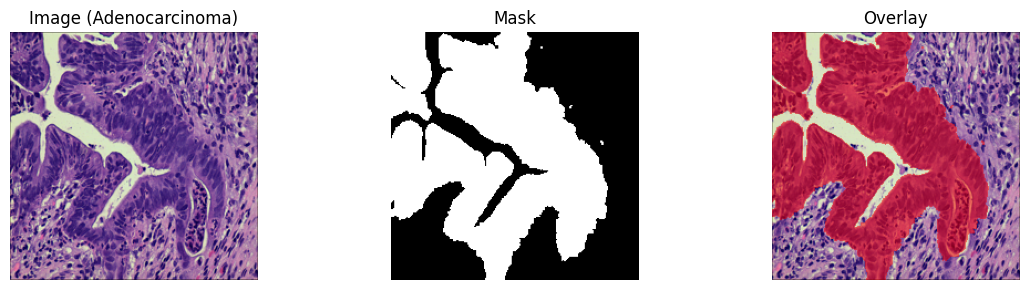

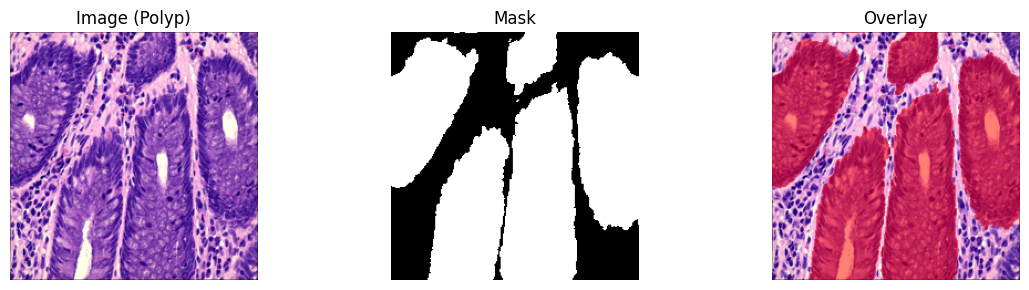

In [ ]:
# ============================================
# 5) IO helpers + quick visualization
# ============================================
def read_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def read_mask(path, thr=0):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return (m > thr).astype(np.uint8)

def show_samples(pairs, n=2):
    for _ in range(n):
        ip, mp, cid = random.choice(pairs)
        img = read_rgb(ip)
        msk = read_mask(mp, cfg.mask_threshold)

        overlay = img.copy()
        overlay[msk == 1] = (0.5 * overlay[msk == 1] + 0.5 * np.array([255, 0, 0])).astype(np.uint8)

        plt.figure(figsize=(12, 3))
        plt.subplot(1, 3, 1); plt.imshow(img); plt.axis('off'); plt.title(f"Image ({CLASS_NAMES[cid]})")
        plt.subplot(1, 3, 2); plt.imshow(msk, cmap='gray'); plt.axis('off'); plt.title("Mask")
        plt.subplot(1, 3, 3); plt.imshow(overlay); plt.axis('off'); plt.title("Overlay")
        plt.tight_layout(); plt.show()

show_samples(train_pairs, n=2)


## 6) Data augmentation
Pathology benefits from augmentations because stain intensity and orientation vary.
These augmentations keep histology structure plausible while improving robustness.


In [ ]:
# ============================================
# 6) Transforms
# ============================================
train_tfms = A.Compose([
    A.Resize(cfg.img_size, cfg.img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=20, p=0.7, border_mode=cv2.BORDER_REFLECT),
    A.ColorJitter(brightness=0.10, contrast=0.10, saturation=0.10, hue=0.03, p=0.7),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
])

val_tfms = A.Compose([
    A.Resize(cfg.img_size, cfg.img_size),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 7) Dataset & DataLoader
Images are normalized to `[0, 1]` and converted to `CHW` tensors.
Masks are stored as `1×H×W` tensors.


In [ ]:
# ============================================
# 7) Dataset / Dataloader
# ============================================
class EBHISegDataset(Dataset):
    def __init__(self, pairs, tfms=None, thr=0):
        self.pairs = pairs
        self.tfms = tfms
        self.thr = thr

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ip, mp, cid = self.pairs[idx]
        img = read_rgb(ip)
        msk = read_mask(mp, self.thr)

        if self.tfms is not None:
            out = self.tfms(image=img, mask=msk)
            img, msk = out['image'], out['mask']

        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))
        msk = msk.astype(np.float32)[None, ...]

        return torch.tensor(img), torch.tensor(msk), torch.tensor(cid)

train_ds = EBHISegDataset(train_pairs, tfms=train_tfms, thr=cfg.mask_threshold)
val_ds   = EBHISegDataset(val_pairs, tfms=val_tfms, thr=cfg.mask_threshold)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                        num_workers=cfg.num_workers, pin_memory=True)

print("Batches per epoch (train):", len(train_loader))


Batches per epoch (train): 111


## 8) Model
**U-Net** is a strong baseline for medical segmentation.
We use a **ResNet34 ImageNet-pretrained encoder** to improve convergence.

Optional: a **classification head** predicts the patch class (auxiliary task).


In [ ]:
# ============================================
# 8) Model: U-Net + optional classification head
# ============================================
class UNetWithClassifier(nn.Module):
    def __init__(self, encoder_name="resnet34", encoder_weights="imagenet", num_classes=6, multitask=True):
        super().__init__()
        self.multitask = multitask

        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=1,
            activation=None
        )

        if multitask:
            enc_ch = self.unet.encoder.out_channels[-1]
            self.cls_head = nn.Sequential(
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten(),
                nn.Linear(enc_ch, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(256, num_classes)
            )

    def forward(self, x):
        seg_logits = self.unet(x)
        if not self.multitask:
            return seg_logits, None
        feats = self.unet.encoder(x)[-1]
        cls_logits = self.cls_head(feats)
        return seg_logits, cls_logits

model = UNetWithClassifier(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_classes=len(CLASS_NAMES),
    multitask=cfg.multitask
).to(device)

print(model.__class__.__name__)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

UNetWithClassifier


## 9) Loss and metric
- **BCEWithLogitsLoss**: stable pixel-wise loss
- **Dice loss**: overlap-focused, helps with class imbalance
- **Dice coefficient** (metric): how well predicted mask overlaps the ground truth


In [ ]:
# ============================================
# 9) Losses + Metrics
# ============================================
bce = nn.BCEWithLogitsLoss()
dice_loss = smp.losses.DiceLoss(mode="binary", from_logits=True)
cls_ce = nn.CrossEntropyLoss()

def dice_coef_from_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    inter = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
    dice = (2 * inter + eps) / (union + eps)
    return dice.mean()


## 10) Optimizer
We use **AdamW** (Adam + decoupled weight decay) as a reliable default.
Mixed precision (AMP) is enabled on GPU to speed training.


In [ ]:
# ============================================
# 10) Optimizer
# ============================================
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scaler = GradScaler(enabled=(cfg.amp and device.type == "cuda"))


/tmp/ipython-input-890792043.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(cfg.amp and device.type == "cuda"))


## 11) Training loop
Each epoch:
- forward pass → compute segmentation loss (and optional classification loss)
- backprop with AMP scaler
- compute Dice on the batch

Validation reports Dice (and optional classification accuracy).


In [ ]:
# ============================================
# 11) Train / Validate loops
# ============================================
def train_one_epoch(model, loader):
    model.train()
    total_loss, total_dice = 0.0, 0.0

    for imgs, masks, cids in tqdm(loader, desc="train", leave=False):
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        cids  = cids.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=(cfg.amp and device.type == "cuda")):
            seg_logits, cls_logits = model(imgs)
            loss_seg = 0.5 * bce(seg_logits, masks) + 0.5 * dice_loss(seg_logits, masks)
            loss = loss_seg

            if cfg.multitask and (cls_logits is not None):
                loss_cls = cls_ce(cls_logits, cids)
                loss = loss_seg + cfg.cls_loss_weight * loss_cls

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            d = dice_coef_from_logits(seg_logits, masks)

        total_loss += loss.item()
        total_dice += d.item()

    n = len(loader)
    return total_loss / n, total_dice / n

@torch.no_grad()
def validate(model, loader):
    model.eval()
    total_loss, total_dice = 0.0, 0.0
    total_acc, n_acc = 0.0, 0

    for imgs, masks, cids in tqdm(loader, desc="val", leave=False):
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        cids  = cids.to(device, non_blocking=True)

        seg_logits, cls_logits = model(imgs)

        loss_seg = 0.5 * bce(seg_logits, masks) + 0.5 * dice_loss(seg_logits, masks)
        loss = loss_seg

        if cfg.multitask and (cls_logits is not None):
            loss_cls = cls_ce(cls_logits, cids)
            loss = loss_seg + cfg.cls_loss_weight * loss_cls

            pred = torch.argmax(cls_logits, dim=1)
            total_acc += (pred == cids).float().sum().item()
            n_acc += cids.numel()

        d = dice_coef_from_logits(seg_logits, masks)
        total_loss += loss.item()
        total_dice += d.item()

    n = len(loader)
    acc = (total_acc / n_acc) if n_acc > 0 else None
    return total_loss / n, total_dice / n, acc


## 12) Model training + checkpointing
We save the best model (highest validation Dice) to `best_model.pt`.


In [ ]:
# ============================================
# 12) Train
# ============================================
best_dice = -1.0
history = []

for epoch in range(1, cfg.epochs + 1):
    tr_loss, tr_dice = train_one_epoch(model, train_loader)
    va_loss, va_dice, va_acc = validate(model, val_loader)

    history.append({
        "epoch": epoch,
        "train_loss": tr_loss,
        "train_dice": tr_dice,
        "val_loss": va_loss,
        "val_dice": va_dice,
        "val_acc": va_acc
    })

    msg = f"Epoch {epoch:02d} | tr_loss={tr_loss:.4f} tr_dice={tr_dice:.4f} | va_loss={va_loss:.4f} va_dice={va_dice:.4f}"
    if va_acc is not None:
        msg += f" va_acc={va_acc:.4f}"
    print(msg)

    if va_dice > best_dice:
        best_dice = va_dice
        torch.save(model.state_dict(), "/content/best_model.pt")
        print("  ✅ Saved best_model.pt")


train:   0%|          | 0/111 [00:00<?, ?it/s]/tmp/ipython-input-3452438673.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(cfg.amp and device.type == "cuda")):


Epoch 01 | tr_loss=0.3765 tr_dice=0.8996 | va_loss=0.2555 va_dice=0.9304 va_acc=0.8036
  ✅ Saved best_model.pt


Epoch 02 | tr_loss=0.2621 tr_dice=0.9343 | va_loss=0.2284 va_dice=0.9397 va_acc=0.8555
  ✅ Saved best_model.pt


Epoch 03 | tr_loss=0.2397 tr_dice=0.9379 | va_loss=0.2232 va_dice=0.9403 va_acc=0.8352
  ✅ Saved best_model.pt


Epoch 04 | tr_loss=0.2205 tr_dice=0.9404 | va_loss=0.2110 va_dice=0.9446 va_acc=0.8420
  ✅ Saved best_model.pt


Epoch 05 | tr_loss=0.2187 tr_dice=0.9436 | va_loss=0.2018 va_dice=0.9463 va_acc=0.8397
  ✅ Saved best_model.pt


Epoch 06 | tr_loss=0.2021 tr_dice=0.9455 | va_loss=0.1953 va_dice=0.9460 va_acc=0.8465


Epoch 07 | tr_loss=0.1900 tr_dice=0.9458 | va_loss=0.1797 va_dice=0.9485 va_acc=0.8781
  ✅ Saved best_model.pt


Epoch 08 | tr_loss=0.1846 tr_dice=0.9475 | va_loss=0.1746 va_dice=0.9476 va_acc=0.8826


Epoch 09 | tr_loss=0.1799 tr_dice=0.9484 | va_loss=0.1773 va_dice=0.9475 va_acc=0.8713


Epoch 10 | tr_loss=0.1772 tr_dice=0.9486 | va_loss=0.1905 va_dice=0.9471 va_acc=0.8736


Epoch 11 | tr_loss=0.1755 tr_dice=0.9490 | va_loss=0.1669 va_dice=0.9492 va_acc=0.9029
  ✅ Saved best_model.pt


Epoch 12 | tr_loss=0.1785 tr_dice=0.9466 | va_loss=0.1816 va_dice=0.9483 va_acc=0.8871


## 13) Learning curves
Plotting Dice and loss helps you detect:
- underfitting (both train/val low)
- overfitting (train improves, val stalls/drops)
- training instability (loss spikes)


,epoch,train_loss,train_dice,val_loss,val_dice,val_acc
0,1,0.376464,0.899577,0.255506,0.930445,0.803612
1,2,0.262060,0.934329,0.228398,0.939730,0.855530
2,3,0.239676,0.937907,0.223151,0.940291,0.835214
3,4,0.220502,0.940396,0.210978,0.944610,0.841986
4,5,0.218737,0.943599,0.201832,0.946295,0.839729
5,6,0.202102,0.945516,0.195278,0.945984,0.846501
6,7,0.189953,0.945839,0.179655,0.948471,0.878104
7,8,0.184593,0.947528,0.174649,0.947554,0.882619
8,9,0.179861,0.948391,0.177350,0.947518,0.871332
9,10,0.177188,0.948566,0.190454,0.947085,0.873589


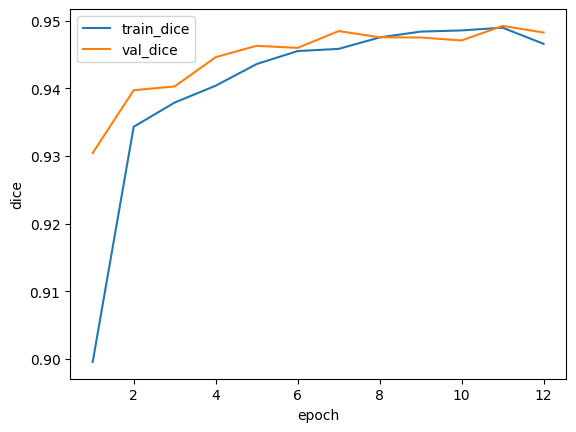

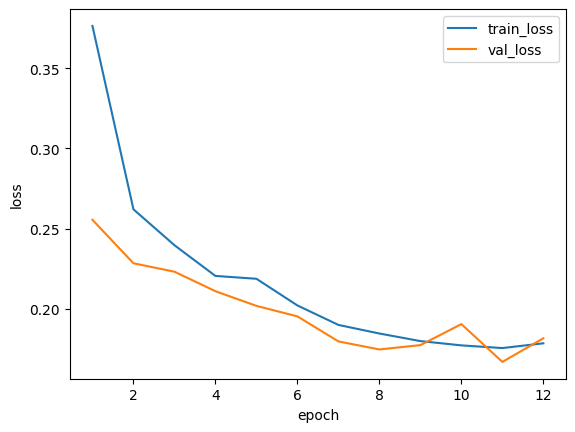

In [ ]:
# ============================================
# 13) Plot curves
# ============================================
import pandas as pd

df = pd.DataFrame(history)
display(df)

plt.figure()
plt.plot(df["epoch"], df["train_dice"], label="train_dice")
plt.plot(df["epoch"], df["val_dice"], label="val_dice")
plt.xlabel("epoch"); plt.ylabel("dice"); plt.legend(); plt.show()

plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()


## 14) Inference + qualitative review
We visualize predicted masks on validation samples.
Qualitative review is important in medical imaging because a single metric can hide failure modes.


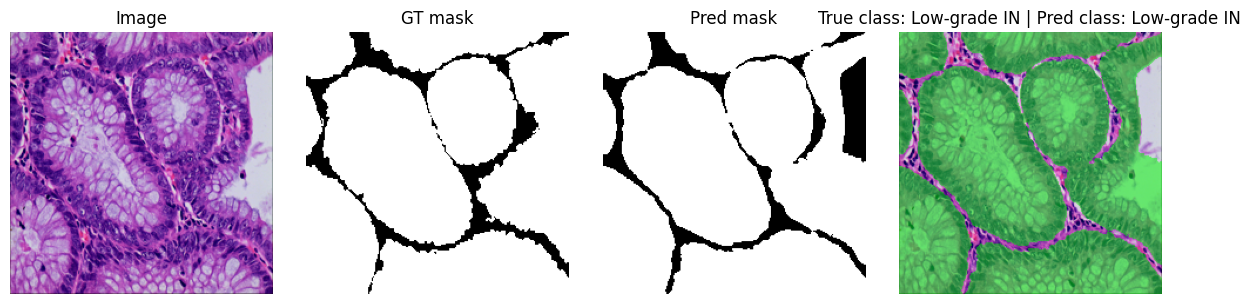

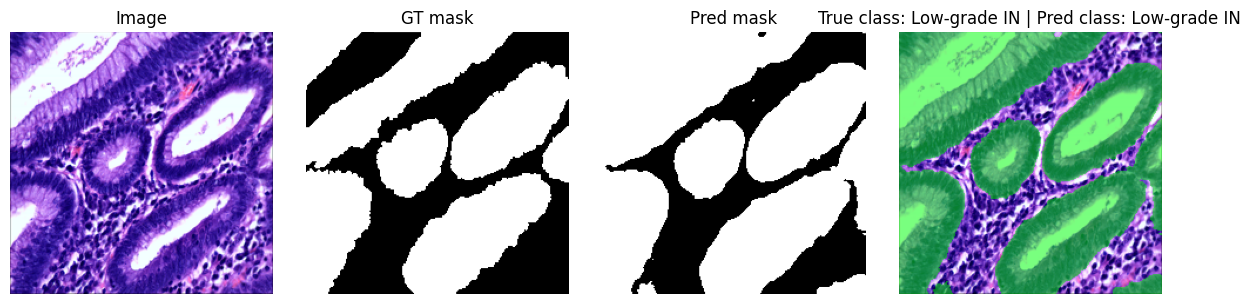

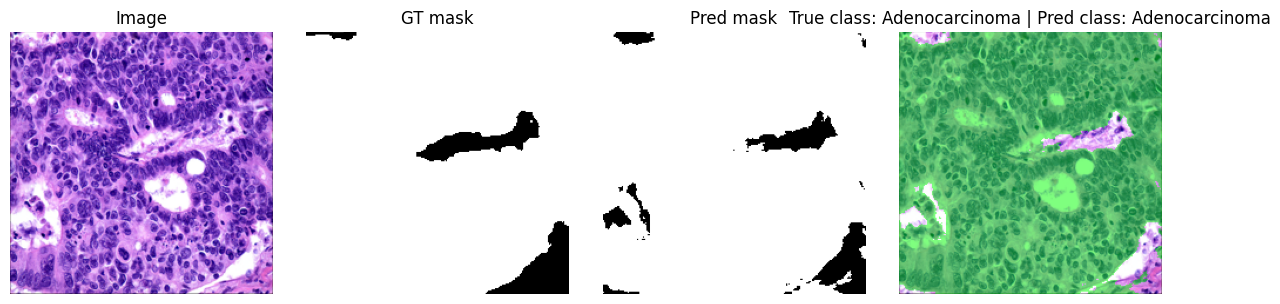

In [ ]:
# ============================================
# 14) Inference visualization
# ============================================
model.load_state_dict(torch.load("/content/best_model.pt", map_location=device))
model.eval()

@torch.no_grad()
def predict_one(ip, mp, cid):
    img0 = read_rgb(ip)
    msk0 = read_mask(mp, cfg.mask_threshold)

    out = val_tfms(image=img0, mask=msk0)
    img = out["image"].astype(np.float32) / 255.0
    img_t = torch.tensor(np.transpose(img, (2, 0, 1))[None, ...]).to(device)

    seg_logits, cls_logits = model(img_t)
    prob = torch.sigmoid(seg_logits)[0, 0].cpu().numpy()
    pred = (prob > 0.5).astype(np.uint8)

    cls_pred = None
    if cfg.multitask and (cls_logits is not None):
        cls_pred = int(torch.argmax(cls_logits, dim=1).item())
    return img0, msk0, pred, prob, cls_pred

for _ in range(3):
    ip, mp, cid = random.choice(val_pairs)
    img0, msk0, pred, prob, cls_pred = predict_one(ip, mp, cid)

    overlay = img0.copy()
    overlay[pred == 1] = (0.5 * overlay[pred == 1] + 0.5 * np.array([0, 255, 0])).astype(np.uint8)

    title = f"True class: {CLASS_NAMES[cid]}"
    if cls_pred is not None:
        title += f" | Pred class: {CLASS_NAMES[cls_pred]}"

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 4, 1); plt.imshow(img0); plt.axis('off'); plt.title('Image')
    plt.subplot(1, 4, 2); plt.imshow(msk0, cmap='gray'); plt.axis('off'); plt.title('GT mask')
    plt.subplot(1, 4, 3); plt.imshow(pred, cmap='gray'); plt.axis('off'); plt.title('Pred mask')
    plt.subplot(1, 4, 4); plt.imshow(overlay); plt.axis('off'); plt.title(title)
    plt.tight_layout(); plt.show()
